importing libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data3_var.xlsx to data3_var.xlsx


scaling using z-score

In [ ]:
df = pd.read_excel('data3_var.xlsx')

In [ ]:
df.head()

,Student,total time spent(secs),low_diff_rt,mid_diff_rt,high_diff_rt,low_diff_rt_correct,mid_diff_rt_correct,high_diff_rt_correct,low_diff_score,mid_diff_score,high_diff_score,total score earned,flag,flag when correct,tab_lst
0,ADITI SUKHIJA,724,31.8,61.4,51.6,31.800000,72.250000,51.600000,1.0,0.8,1.0,14,10,9,0
1,AKARSH KUMAR,1491,37.8,74.2,186.2,20.000000,74.200000,231.666667,0.4,1.0,0.6,10,8,6,4
2,ANJALI ARORA,897,28.6,34.0,116.8,38.333333,32.000000,123.250000,0.6,0.8,0.8,11,12,9,1
3,ANJALI NA,1273,52.4,93.6,108.6,52.400000,106.000000,78.500000,1.0,0.8,0.8,13,7,6,0
4,ATUL NA,676,30.0,57.6,47.6,31.500000,68.666667,40.000000,0.8,0.6,0.6,10,5,4,15


each value that is missing ->

In [ ]:
#df.loc[df['low_diff_rt_correct'].isna()]
#df.loc[df['mid_diff_rt_correct'].isna()]
#df.loc[df['high_diff_rt_correct'].isna()]

 since the amount of data missing is quite low, we can simply impute the data using the 'mean' value

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df[['low_diff_rt_correct','mid_diff_rt_correct','high_diff_rt_correct']]=imputer.fit_transform(df[['low_diff_rt_correct','mid_diff_rt_correct','high_diff_rt_correct']])

In [ ]:
del df['Student']

In [ ]:
scaled_df = df.apply(zscore)

In [ ]:
scaled_df.head(2)

,total time spent(secs),low_diff_rt,mid_diff_rt,high_diff_rt,low_diff_rt_correct,mid_diff_rt_correct,high_diff_rt_correct,low_diff_score,mid_diff_score,high_diff_score,total score earned,flag,flag when correct,tab_lst
0,-0.424665,-0.198545,0.003539,-0.667942,-0.213311,0.502066,-0.641299,1.172965,0.512605,1.336306,1.190181,0.594417,1.248477,-1.020204
1,1.621353,0.195455,0.315714,2.436430,-0.858320,0.575555,3.002989,-1.127851,1.219169,-0.267261,-0.023804,-0.271733,0.054621,-0.680136


In [ ]:
var_lst = list(scaled_df)
var_lst#list of variables

['total time spent(secs)',
 'low_diff_rt',
 'mid_diff_rt',
 'high_diff_rt',
 'low_diff_rt_correct',
 'mid_diff_rt_correct',
 'high_diff_rt_correct',
 'low_diff_score',
 'mid_diff_score',
 'high_diff_score',
 'total score earned',
 'flag',
 'flag when correct',
 'tab_lst']

#####optimal numbers of clusters (elbow and silhouette method)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# elbow method
k_rng = range(1,10)
sse = []
for k in k_rng:
  km = KMeans(n_clusters=k)
  km.fit(scaled_df[var_lst])
  sse.append(km.inertia_)

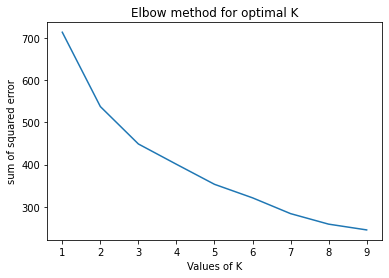

In [ ]:
plt.xlabel('Values of K')
plt.ylabel('sum of squared error')
plt.title('Elbow method for optimal K')
plt.plot(k_rng,sse)

In [ ]:
#sil method

sil = []
k_rng = range(2,8)

for k in k_rng:
  kmeans = KMeans(n_clusters = k).fit(scaled_df[var_lst])
  labels = kmeans.labels_
  sil.append(silhouette_score(scaled_df[var_lst], labels, metric = 'euclidean'))

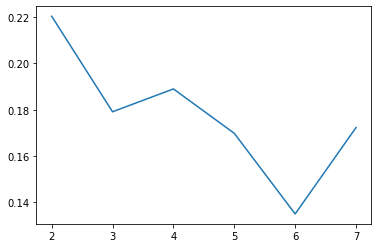

In [ ]:
plt.plot(k_rng,sil)

##### k means and pca

([<matplotlib.axis.XTick at 0x7f6cb1986c10>,
 <a list of 14 Text major ticklabel objects>)

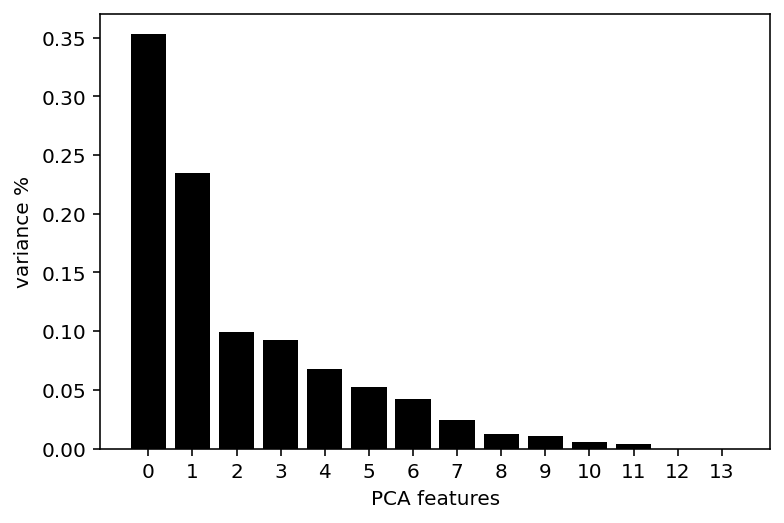

In [ ]:
# finding the optimal number of components which capture the greatest amount of variance in the data
# imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# standardize the data to have a mean of 0 and a variance of 1
X_std = StandardScaler().fit_transform(scaled_df)

# create a PCA instance: pca
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(X_std)

# plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

the plot above shows that the first two components explain the majority of the variance in our data

In [ ]:
## running the kmeans clustering model by taking k = 4 as suggested by elbow, silhouette and other methods
km = KMeans(n_clusters = 4)
y_predicted = km.fit_predict(scaled_df[var_lst])
scaled_df['cluster_k_four'] = y_predicted

In [ ]:
pca = PCA(n_components=2) #specifying how many components we want to keep when creating the pca object
pca.fit(scaled_df)
x_pca = pca.transform(scaled_df)

In [ ]:
print(scaled_df.shape)
print(x_pca.shape)

(51, 15)
(51, 2)


15 variables to 2 pca components

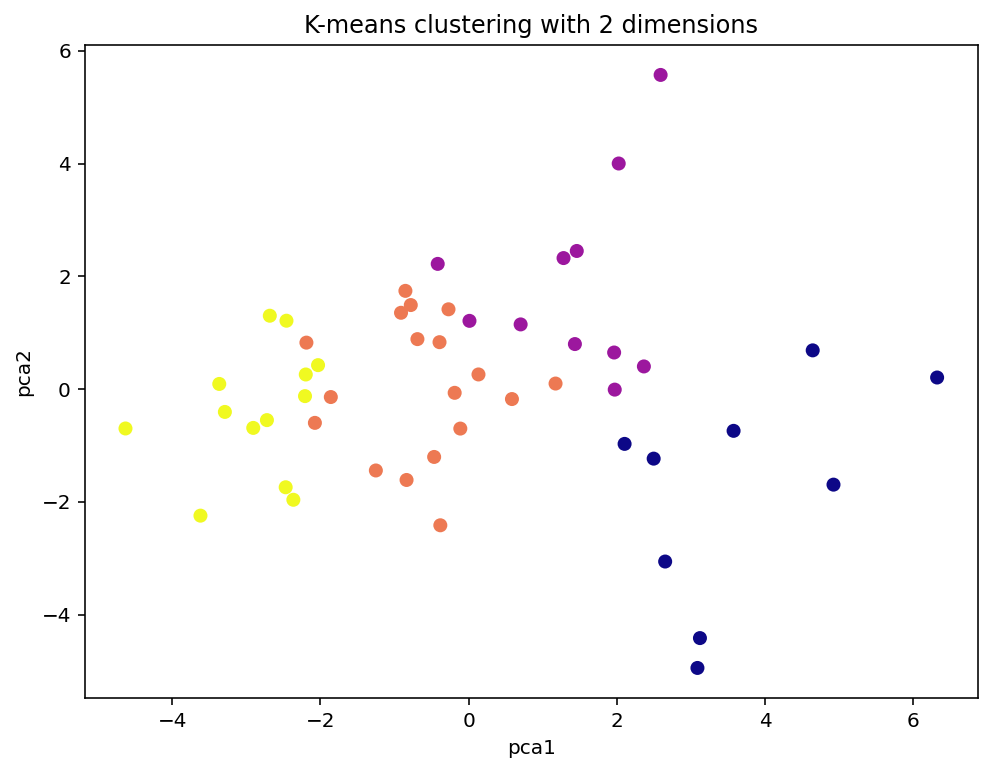

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=scaled_df['cluster_k_four'],cmap='plasma')
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.title('K-means clustering with 2 dimensions')
plt.show()

In [ ]:
#adding x_pca to scaled_df as two columns
scaled_df["x_pca1"], scaled_df["x_pca2"] = x_pca.T

#####some better viz

In [ ]:
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#d9df20']
scaled_df['c'] = scaled_df.cluster_k_four.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

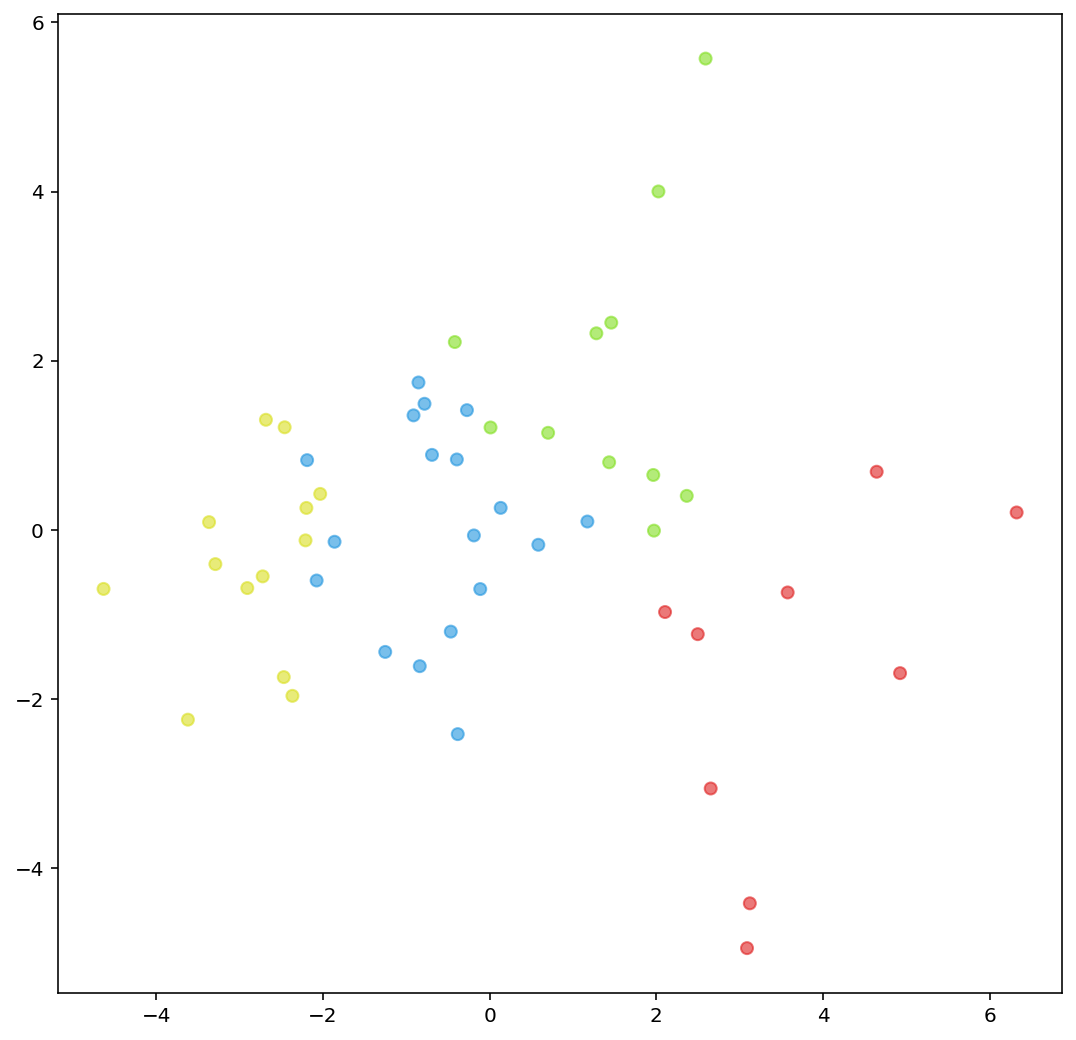

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(scaled_df["x_pca1"], scaled_df["x_pca2"], c=scaled_df.c, alpha = 0.6)
#plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='^',label='centroid')

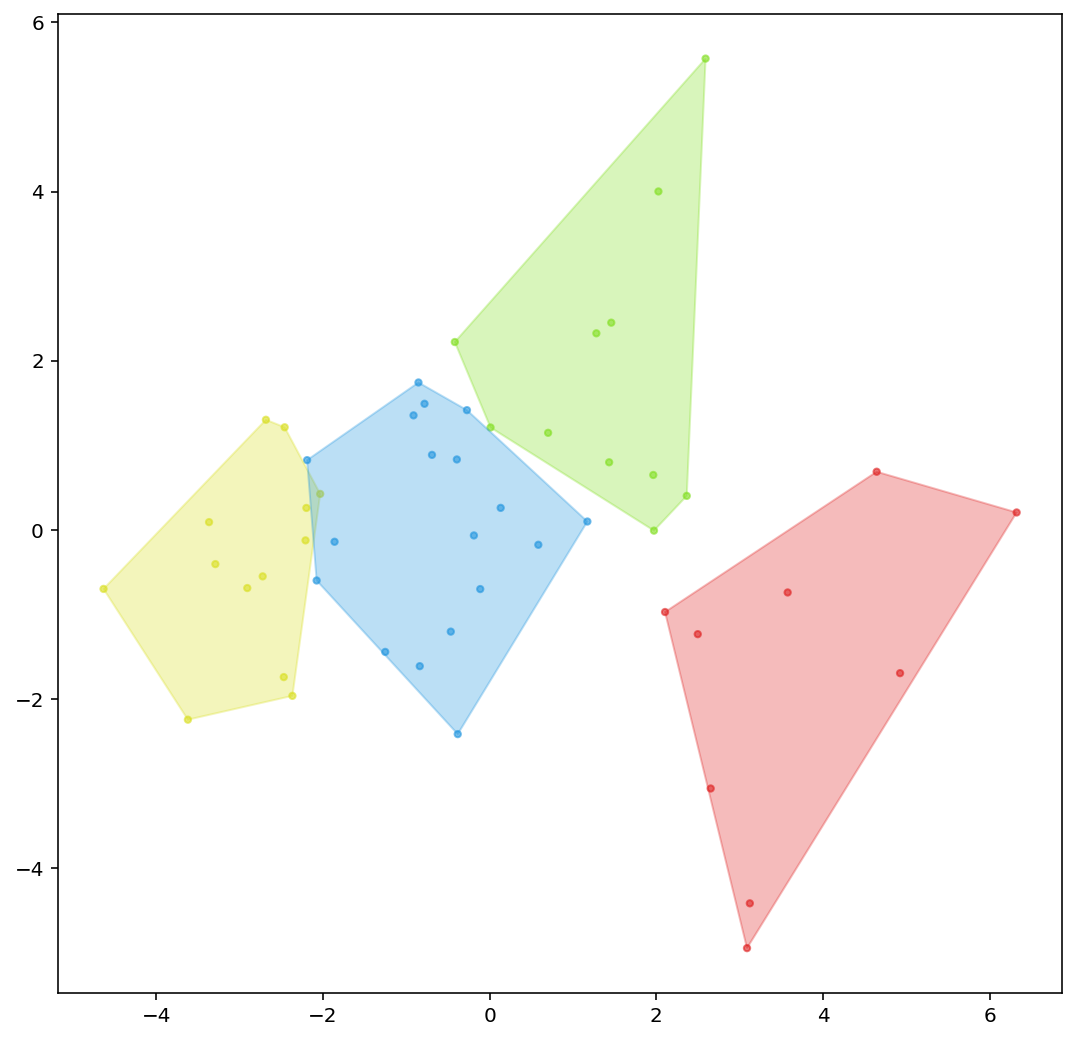

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.pyplot import Line2D
fig, ax = plt.subplots(1, figsize=(9,9))
# plot data
plt.scatter(scaled_df['x_pca1'], scaled_df['x_pca2'], c=scaled_df.c, alpha = 0.6, s=10)
# plot centers
#plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)# draw enclosure
for i in scaled_df.cluster_k_four.unique():
    points = scaled_df[scaled_df.cluster_k_four == i][['x_pca1', 'x_pca2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])

#####interpreting the components

In [ ]:
pca.components_

array([[-0.33968896, -0.26688083, -0.18997848, -0.31399759, -0.22839867,
        -0.2445436 , -0.24546983, -0.27415516, -0.23851317, -0.24539994,
        -0.30383064,  0.06891786, -0.1917916 , -0.14934178, -0.397563  ],
       [-0.2558176 , -0.2198921 , -0.21049586, -0.1660683 , -0.2435101 ,
        -0.26492679, -0.24280122,  0.28891181,  0.27112011,  0.32131256,
         0.35241104,  0.25680621,  0.40963078,  0.07906691,  0.03836652]])

In [ ]:
var_lst_cluster = list(scaled_df)[:15]#reqd list of variables
var_lst_cluster

['total time spent(secs)',
 'low_diff_rt',
 'mid_diff_rt',
 'high_diff_rt',
 'low_diff_rt_correct',
 'mid_diff_rt_correct',
 'high_diff_rt_correct',
 'low_diff_score',
 'mid_diff_score',
 'high_diff_score',
 'total score earned',
 'flag',
 'flag when correct',
 'tab_lst',
 'cluster_k_four']

In [ ]:
df_comp = pd.DataFrame(pca.components_,columns=var_lst_cluster)

In [ ]:
df_comp

,total time spent(secs),low_diff_rt,mid_diff_rt,high_diff_rt,low_diff_rt_correct,mid_diff_rt_correct,high_diff_rt_correct,low_diff_score,mid_diff_score,high_diff_score,total score earned,flag,flag when correct,tab_lst,cluster_k_four
0,-0.339689,-0.266881,-0.189978,-0.313998,-0.228399,-0.244544,-0.245470,-0.274155,-0.238513,-0.245400,-0.303831,0.068918,-0.191792,-0.149342,-0.397563
1,-0.255818,-0.219892,-0.210496,-0.166068,-0.243510,-0.264927,-0.242801,0.288912,0.271120,0.321313,0.352411,0.256806,0.409631,0.079067,0.038367


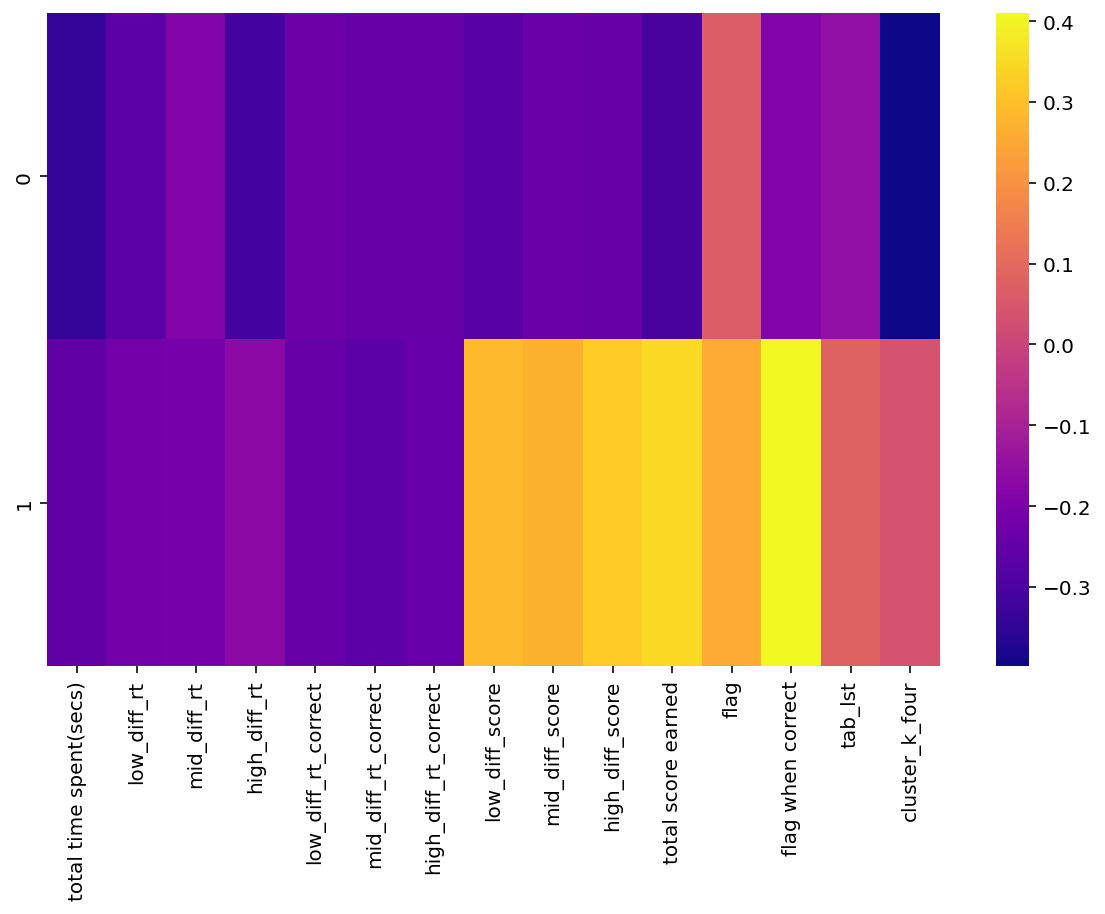

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df_comp,cmap='plasma',)

This heatmap represents the correlation between the various features and the principal components itself. Pca basically finds the features that explain the most variance in our data.

##### Feature selection

1. Information gain(one of the filter methods)

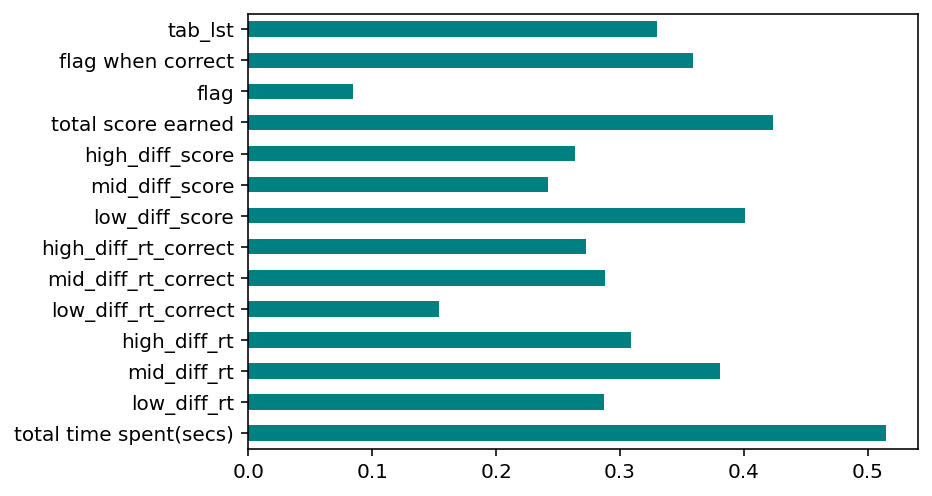

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = scaled_df[var_lst]  #independent columns
y = scaled_df['cluster_k_four']   #target column i.e cluster

importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, var_lst)
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

###### 2. Feature importance

[0.11007889 0.06697762 0.05505887 0.08319055 0.04758086 0.04932679
 0.05908533 0.10033023 0.0450448  0.0522589  0.0807852  0.04958686
 0.07597994 0.12471517]


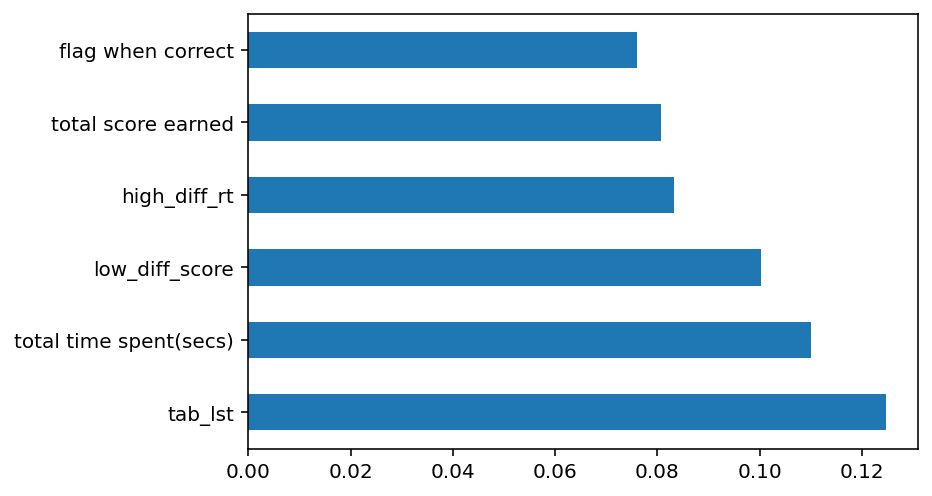

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

3.Correlation Matrix with Heatmap

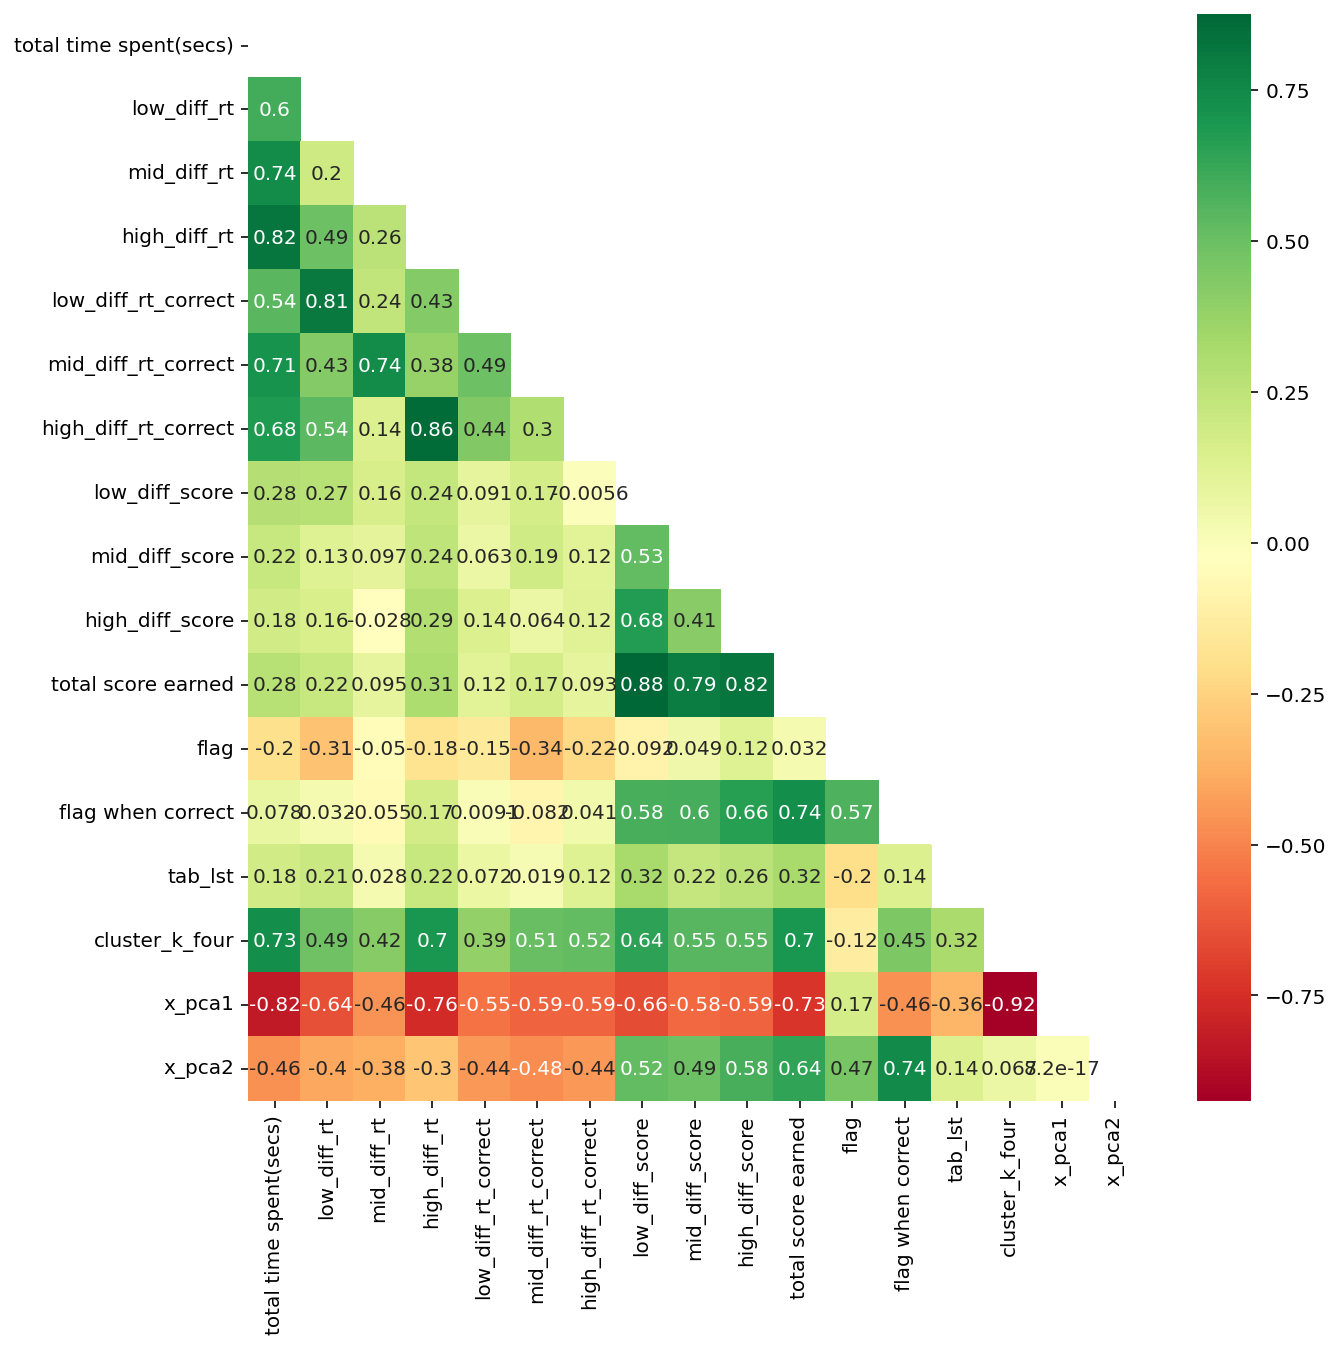

In [ ]:
import seaborn as sns
# get correlations of each features in dataset
corrmat = scaled_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# plot heat map
mask = np.triu(np.ones_like(corrmat))
g=sns.heatmap(scaled_df[top_corr_features].corr(),annot=True,cmap="RdYlGn", mask=mask)

Issues
1. nan values, solved using data imputation
2. centroids?
3. sil method k not const

Advice:
1. remove pca
2. (2 step clustering) take feature importance,info gain (6 variables, number of clusters = 2)
3. ans revision>0 AND score=1 AND tab_switch>0
4. kendall taus